In [1]:
import os
import cv2

import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt
import scipy
from tqdm.notebook import tqdm 

In [2]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv') 
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        1549 non-null   object 
 1   Weeks          1549 non-null   int64  
 2   FVC            1549 non-null   int64  
 3   Percent        1549 non-null   float64
 4   Age            1549 non-null   int64  
 5   Sex            1549 non-null   object 
 6   SmokingStatus  1549 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 84.8+ KB


In [4]:
from statsmodels.formula.api import ols

#fit multiple linear regression model
model_stats = ols('FVC ~  Weeks + Percent + Age + Sex + SmokingStatus',
            data=train).fit()

#view model summary
print(model_stats.summary())

                            OLS Regression Results                            
Dep. Variable:                    FVC   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     1309.
Date:                Mon, 09 Nov 2020   Prob (F-statistic):               0.00
Time:                        14:00:54   Log-Likelihood:                -11214.
No. Observations:                1549   AIC:                         2.244e+04
Df Residuals:                    1542   BIC:                         2.248e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

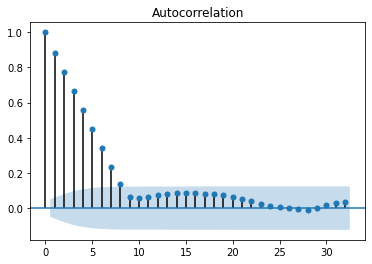

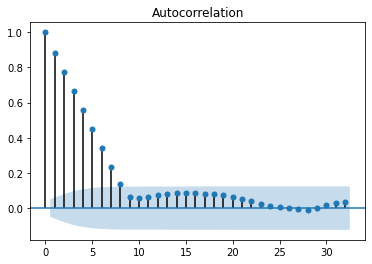

In [5]:
# observations are not independent
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(model_stats.resid)

In [6]:
train_org = train.copy()

In [7]:
def get_tab(df):
    vector = [(df.Age.values[0] - 30) / 30] 
    
    if df.Sex.values[0] == 'Male':
       vector.append(0)
    else:
       vector.append(1)
    
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([0,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([1,1])
    else:
        vector.extend([1,0])
    return np.array(vector) 

In [8]:
weeks_to_pred = np.array([i for i in range(-12, 134)]).astype(np.float32)

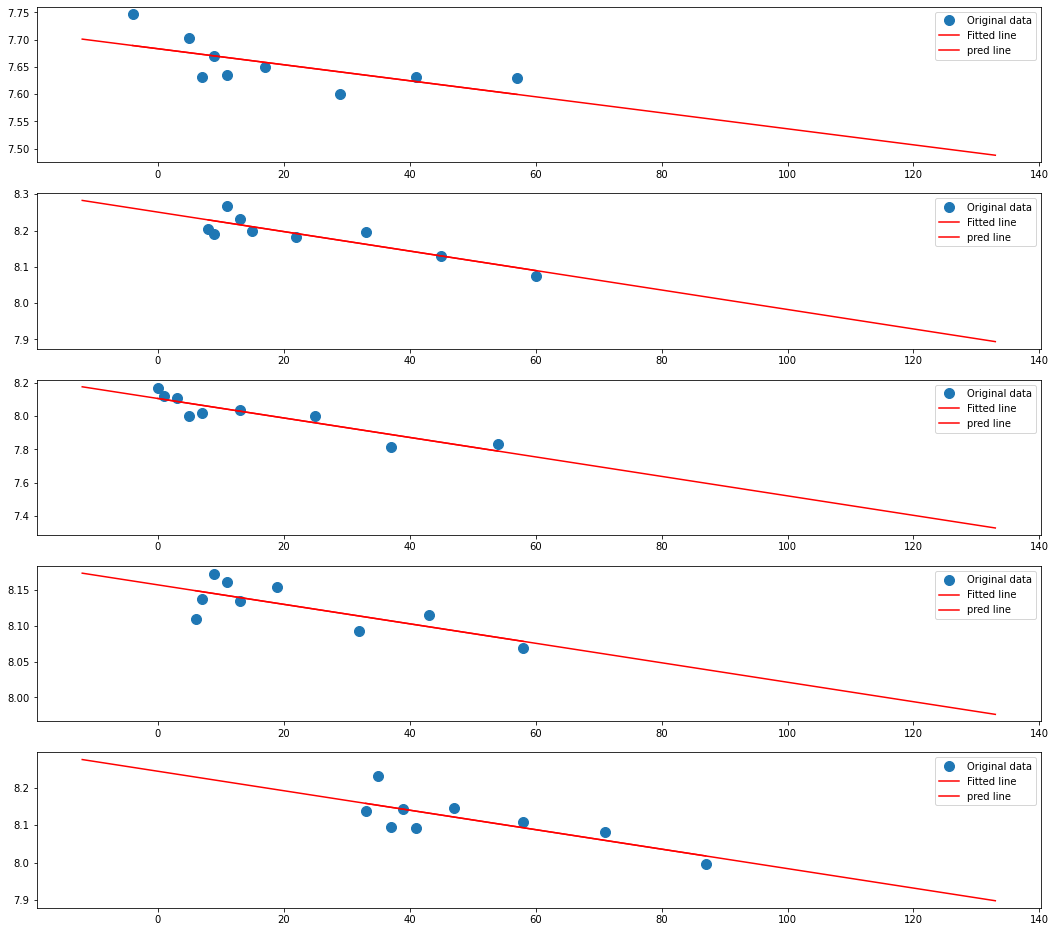

In [9]:
%matplotlib inline
from scipy import optimize
rows = 6
cols = 1
z = 1
plt.figure(figsize=(18, 20))
l_ = []
A = {} 
TAB = {} 
P = [] 
for i, p in tqdm(enumerate(train.Patient.unique())):
    sub = train.loc[train.Patient == p, :] 
    fvc = np.log(sub.FVC.values)
    weeks = sub.Weeks.values
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc, rcond=-1)[0]    
    #exp decay
    if z < 6:
        # linear plot
        plt.subplot(rows, cols, z)
        plt.plot(weeks, fvc, 'o', label='Original data', markersize=10)
        plt.plot(weeks, a*weeks + b, 'r', label='Fitted line')
        plt.plot(weeks_to_pred, a*weeks_to_pred + b, 'r', label='pred line')
        
        plt.legend()
        z +=1
    A[p] = a
    TAB[p] = get_tab(sub)
    P.append(p)

In [10]:
A_list = []
for i in list(A.values()):
    if i > 0:
        val = i - (np.max(list(A.values())) + 0.00000001)
    else:
        val = i
    A_list.append(val)

x=0
for i in A.keys():
    A[i] = A_list[x]
    x += 1

## CNN for coeff prediction

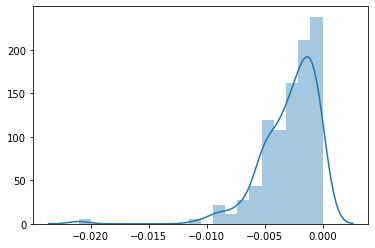

In [11]:
import seaborn as sns

sns.distplot(list(A.values()), bins=20);

In [12]:
def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize((d.pixel_array - d.RescaleIntercept) / (d.RescaleSlope * 1000), (512, 512))

In [13]:
from tensorflow.keras.utils import Sequence

class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=32):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}
        for p in train.Patient.unique():
            ldir = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
            numb = [float(i[:-4]) for i in ldir]
            self.train_data[p] = [i for i in os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/') 
                                  if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15]
    
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size)
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0]
                img = get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{k}/{i}')
                mask = cv2.resize(cv2.imread(f'../input/osic-pulmonary-fibrosis-progression-lungs-mask/mask_clear/mask_clear/{k}/{i[:-4]}.jpg', 0), (512, 512))> 0
                img[~mask] = 0
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x, tab] , a

In [14]:
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, Add, Conv2D, AveragePooling2D, 
    LeakyReLU, Concatenate 
)

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Nadam

from keras import backend as K

def get_exp(beta=0.025):
    def exp_coef(x, beta=beta):
        #orig = x
        #x = tf.where(orig<=0, K.tanh(x*beta), x)
        #x = tf.where(orig>0, -K.tanh(x*beta), x)
        return 0.5 * K.tanh(x*beta) - beta
    return exp_coef
    
def get_model(shape=(512, 512, 1)):
    def res_block(x, n_features):
        _x = x
        x = BatchNormalization()(x)
        x = LeakyReLU(0.05)(x)
    
        x = Conv2D(n_features, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
        x = Add()([_x, x])
        return x
    
    inp = Input(shape=shape)
    
    # 512
    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(inp)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.05)(x)
    
    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.05)(x)
    
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # 256
    x = Conv2D(8, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    for _ in range(2):
        x = res_block(x, 8)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # 128
    x = Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    for _ in range(2):
        x = res_block(x, 16)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # 64
    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    for _ in range(3):
        x = res_block(x, 32)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # 32
    x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    for _ in range(3):
        x = res_block(x, 64)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)    
    
    # 16
    x = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    for _ in range(3):
        x = res_block(x, 128)
        
    # 16
    x = GlobalAveragePooling2D()(x)
    
    inp2 = Input(shape=(4,))
    x2 = tf.keras.layers.GaussianNoise(0.2)(inp2)
    x = Concatenate()([x, x2]) 
    x = Dropout(0.5)(x) 
    x = Dense(1, activation='tanh')(x)
    x = Dense(1, activation=get_exp(beta=0.025))(x)

    return Model([inp, inp2] , x)

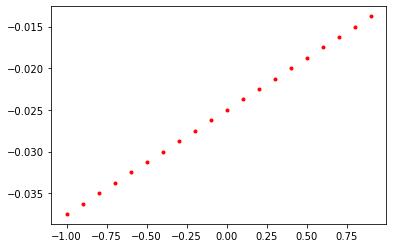

In [15]:
def exp_coef(x, beta=1.0):
        orig = x
        #x = tf.where(orig<=0, K.tanh(x*beta), x)
        #x = tf.where(orig>0, -K.tanh(x*beta), x)
        return 0.5 * K.tanh(x*beta) - beta
a = [i / 10 for i in range(-10, 10)]
plt.plot(a, exp_coef(tf.convert_to_tensor(np.array(a).astype(np.float32)), beta=0.025), 'r.')

In [16]:
model = get_model() 
model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 512, 512, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [17]:
from tensorflow_addons.optimizers import RectifiedAdam

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mean_absolute_error']) 

In [18]:
from sklearn.model_selection import train_test_split 

tr_p, vl_p = train_test_split(P, 
                              shuffle=True, 
                              train_size= 0.8)

In [19]:
er = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-6,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [20]:
model.fit_generator(IGenerator(keys=tr_p, 
                               a = A, 
                               tab = TAB), 
                    steps_per_epoch = 100,
                    validation_data=IGenerator(keys=vl_p, 
                               a = A, 
                               tab = TAB),
                    validation_steps = 20, 
                    callbacks = [er], 
                    epochs=30)

Epoch 1/30
100/100 [==============================] - 60s 598ms/step - loss: 1.4569e-04 - mean_absolute_error: 0.0117 - val_loss: 1.1046e-04 - val_mean_absolute_error: 0.0103
Epoch 2/30
100/100 [==============================] - 57s 566ms/step - loss: 9.3710e-05 - mean_absolute_error: 0.0095 - val_loss: 6.9676e-05 - val_mean_absolute_error: 0.0080
Epoch 3/30
100/100 [==============================] - 54s 543ms/step - loss: 5.8730e-05 - mean_absolute_error: 0.0073 - val_loss: 4.3707e-05 - val_mean_absolute_error: 0.0062
Epoch 4/30
100/100 [==============================] - 52s 517ms/step - loss: 3.7095e-05 - mean_absolute_error: 0.0057 - val_loss: 2.6127e-05 - val_mean_absolute_error: 0.0048
Epoch 5/30
100/100 [==============================] - 50s 502ms/step - loss: 2.3160e-05 - mean_absolute_error: 0.0043 - val_loss: 1.6973e-05 - val_mean_absolute_error: 0.0038
Epoch 6/30
100/100 [==============================] - 49s 488ms/step - loss: 1.5113e-05 - mean_absolute_error: 0.0033 - val_l

In [21]:
def score(fvc_true, fvc_pred, sigma):
    sigma_clip = np.maximum(sigma, 70)
    delta = np.abs(fvc_true - fvc_pred)
    delta = np.minimum(delta, 1000)
    sq2 = np.sqrt(2)
    metric = (delta / sigma_clip)*sq2 + np.log(sigma_clip* sq2)
    return np.mean(metric)

In [22]:
from tqdm.notebook import tqdm

metric = []
for q in tqdm(range(1, 10)):
    m = []
    for p in vl_p:
        x = [] 
        tab = [] 

        if p in ['ID00011637202177653955184', 'ID00052637202186188008618']:
            continue

        ldir = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
        for i in ldir:
            if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15:
                x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/{i}')) 
                tab.append(get_tab(train.loc[train.Patient == p, :])) 
        if len(x) < 1:
            continue
        tab = np.array(tab) 

        x = np.expand_dims(x, axis=-1) 
        _a = model.predict([x, tab])
        a = _a
        a = np.quantile(_a, q / 10)

        percent_true = train.Percent.values[train.Patient == p]
        fvc_true = train.FVC.values[train.Patient == p]
        weeks_true = train.Weeks.values[train.Patient == p]


        fvc = np.exp(a*(weeks_true - weeks_true[0]) + np.log(fvc_true[0]))
        sigma = percent_true[0] - np.exp(abs(weeks_true - weeks_true[0]) * a)
        #print('org:{}, pred:{}'.format(A[p], np.mean(a)))
        m.append(score(fvc_true, fvc, sigma))
    print(np.mean(m))
    metric.append(np.mean(m))

7.527802020335483
7.527802020335483
7.527802020335483
7.527802020335483
7.527802020335483
7.527802020335483
7.527802020335483
7.527802020335483
7.527802020335483



## Predict

In [23]:
q = (np.argmin(metric) + 1)/ 10
q

0.1

In [24]:
sub = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv') 
sub.head() 

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2000,100
1,ID00421637202311550012437_-12,2000,100
2,ID00422637202311677017371_-12,2000,100
3,ID00423637202312137826377_-12,2000,100
4,ID00426637202313170790466_-12,2000,100


In [25]:
test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')

In [26]:
A_test, B_test, P_test,W, FVC= {}, {}, {},{},{} 
STD, WEEK = {}, {} 
for p in test.Patient.unique():
    x = [] 
    tab = [] 
    ldir = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/')
    for i in ldir:
        if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15:
            x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/{i}')) 
            tab.append(get_tab(test.loc[test.Patient == p, :])) 
    if len(x) <= 1:
        continue
    tab = np.array(tab) 
            
    x = np.expand_dims(x, axis=-1) 
    _a = model.predict([x, tab]) 
    a = _a
    a = np.quantile(_a, q)
    A_test[p] = a
    B_test[p] = np.log(test.FVC.values[test.Patient == p]) - (test.Weeks.values[test.Patient == p]) * a
    P_test[p] = test.Percent.values[test.Patient == p] 
    WEEK[p] = test.Weeks.values[test.Patient == p]

In [27]:
for k in sub.Patient_Week.values:
    p, w = k.split('_')
    w = int(w) 
    fvc = np.exp(w*A_test[p] + B_test[p])
    sub.loc[sub.Patient_Week == k, 'FVC'] = fvc
    sub.loc[sub.Patient_Week == k, 'Confidence'] = P_test[p] - np.exp(A_test[p] * abs(WEEK[p] - w))
    

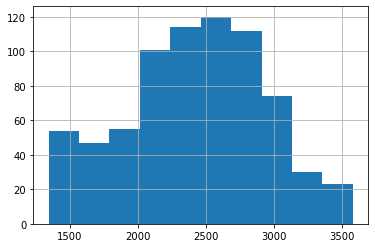

In [28]:
sub.FVC.hist()

In [29]:
sub[["Patient_Week","FVC","Confidence"]].to_csv("submission_img.csv", index=False)
img_sub = sub[["Patient_Week","FVC","Confidence"]].copy()

In [30]:
ROOT = "../input/osic-pulmonary-fibrosis-progression"
BATCH_SIZE=128

tr = pd.read_csv(f"{ROOT}/train.csv")
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(f"{ROOT}/test.csv")

print("add infos")
sub = pd.read_csv(f"{ROOT}/sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

add infos


In [31]:
tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = tr.append([chunk, sub])

data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [32]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base

In [33]:
COLS = ['Sex','SmokingStatus'] #,'Age'
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)

In [34]:
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
FE += ['age','percent','week','BASE']

In [35]:
tr = data.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data

In [36]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")

def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)

def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)

def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss

def make_model(nh):
    z = L.Input((nh,), name="Patient")
    x = L.Dense(100, activation="relu", name="d1")(z)
    x = L.Dense(100, activation="relu", name="d2")(x)
    #x = L.Dense(100, activation="relu", name="d3")(x)
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    #model.compile(loss=qloss, optimizer="adam", metrics=[score])
    model.compile(loss=mloss(0.8375), optimizer=tf.keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False), metrics=[score])
    return model

In [37]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

In [38]:
y = tr['FVC'].values
z = tr[FE].values
ze = sub[FE].values
nh = z.shape[1]
pe = np.zeros((ze.shape[0], 3))
pred = np.zeros((z.shape[0], 3))

NFOLD = 5 # originally 5
kf = KFold(n_splits=NFOLD)

In [39]:
%%time
cnt = 0
EPOCHS = 800
for tr_idx, val_idx in kf.split(z):
    cnt += 1
    print(f"FOLD {cnt}")
    net = make_model(nh)
    net.fit(z[tr_idx], y[tr_idx], batch_size=BATCH_SIZE, epochs=EPOCHS, 
            validation_data=(z[val_idx], y[val_idx]), verbose=0) #
    print("train", net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE))
    print("val", net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE))
    print("predict val...")
    pred[val_idx] = net.predict(z[val_idx], batch_size=BATCH_SIZE, verbose=0)
    print("predict test...")
    pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD

FOLD 1
train [40.8542366027832, 6.495644569396973]
val [49.51698684692383, 6.7195916175842285]
predict val...
predict test...
FOLD 2
train [41.12504959106445, 6.501265525817871]
val [48.122310638427734, 6.657367706298828]
predict val...
predict test...
FOLD 3
train [39.301795959472656, 6.427008152008057]
val [56.531986236572266, 6.743476867675781]
predict val...
predict test...
FOLD 4
train [42.81867599487305, 6.541779518127441]
val [42.97727584838867, 6.537622928619385]
predict val...
predict test...
FOLD 5
train [41.341468811035156, 6.485561370849609]
val [50.093788146972656, 6.7407050132751465]
predict val...
predict test...
CPU times: user 4min 3s, sys: 13.9 s, total: 4min 17s
Wall time: 3min 42s


In [40]:
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)

139.2410971377494 230.44501153902434


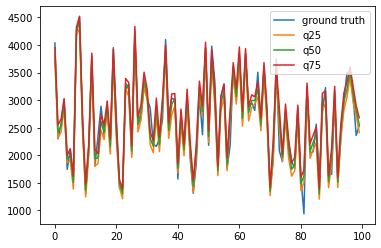

In [41]:
idxs = np.random.randint(0, y.shape[0], 100)
plt.plot(y[idxs], label="ground truth")
plt.plot(pred[idxs, 0], label="q25")
plt.plot(pred[idxs, 1], label="q50")
plt.plot(pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()

In [42]:
# PREDICTION
sub['FVC1'] = 1.*pe[:, 1]
sub['Confidence1'] = pe[:, 2] - pe[:, 0]
subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()
subm.loc[~subm.FVC1.isnull()].head(10)

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,3020,100.0,2858.355957,241.746094
1541,ID00419637202311204720264_-11,3020,100.0,2855.959290,242.948669
1542,ID00419637202311204720264_-10,3020,100.0,2853.562622,244.151367
1543,ID00419637202311204720264_-9,3020,100.0,2851.165955,245.354004
1544,ID00419637202311204720264_-8,3020,100.0,2848.769287,246.556763
1545,ID00419637202311204720264_-7,3020,100.0,2846.372559,247.759155
1546,ID00419637202311204720264_-6,3020,100.0,2843.975952,248.962097
1547,ID00419637202311204720264_-5,3020,100.0,2841.579285,250.164612
1548,ID00419637202311204720264_-4,3020,100.0,2839.182739,251.367371
1549,ID00419637202311204720264_-3,3020,100.0,2836.785950,252.570007


In [43]:
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

In [44]:
otest = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1

In [45]:
reg_sub = subm[["Patient_Week","FVC","Confidence"]].copy()

In [46]:
df1 = img_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)
df2 = reg_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)

In [47]:
df = df1[['Patient_Week']].copy()
df['FVC'] = 0.25*df1['FVC'] + 0.75*df2['FVC']
df['Confidence'] = 0.25*df1['Confidence'] + 0.75*df2['Confidence']
df.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-1,2894.426851,208.440937
1,ID00419637202311204720264_-10,2930.531264,200.421424
2,ID00419637202311204720264_-11,2934.592918,199.520083
3,ID00419637202311204720264_-12,2938.661059,198.618831
4,ID00419637202311204720264_-2,2898.327044,207.598848


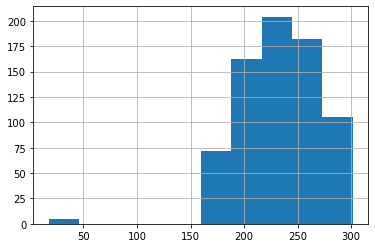

In [48]:
df['Confidence'].hist()

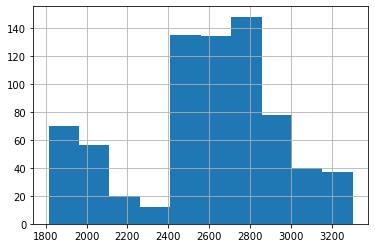

In [49]:
df['FVC'].hist()

In [50]:
df.to_csv('submission.csv', index=False)